In [1]:
#Imports
from tcn import TCN, tcn_full_summary
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
train_data = pd.read_csv('../Implementation/CSVFiles/2022-09-26-18-56-30-joint_states.csv')
train_data['.position'] = train_data['.position'].str.strip('()')
train_data['.velocity'] = train_data['.velocity'].str.strip('()')
train_data['.effort'] = train_data['.effort'].str.strip('()')
time_stamp = train_data[['.header.stamp.nsecs']]
position = train_data['.position'].str.split(',', expand=True)
velocity = train_data['.velocity'].str.split(',', expand=True)
effort = train_data['.effort'].str.split(',', expand=True)
features = pd.concat([position, velocity, effort], axis=1)

In [3]:
x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled)

In [4]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.650313,0.529148,0.489321,0.64699,0.504919,0.510995,0.746495,0.496418,0.444459,0.724485,...,0.37337,0.596550,0.758801,0.337569,0.550196,0.363930,0.551238,0.570475,0.573869,0.519977
1,0.650313,0.529160,0.489321,0.64699,0.504908,0.510995,0.746494,0.496435,0.444459,0.724485,...,0.37337,0.596550,0.758815,0.337569,0.550197,0.363915,0.551238,0.570476,0.573900,0.519977
2,0.650313,0.529172,0.489321,0.64699,0.504898,0.510995,0.746494,0.496452,0.444459,0.724485,...,0.37337,0.596551,0.758830,0.337569,0.550197,0.363899,0.551238,0.570476,0.573931,0.519977
3,0.650313,0.529184,0.489321,0.64699,0.504887,0.510994,0.746494,0.496469,0.444459,0.724484,...,0.37337,0.596551,0.758845,0.337569,0.550197,0.363884,0.551238,0.570476,0.573962,0.519977
4,0.650312,0.529196,0.489321,0.64699,0.504876,0.510994,0.746494,0.496486,0.444459,0.724484,...,0.37337,0.596551,0.758859,0.337569,0.550197,0.363868,0.551238,0.570476,0.573994,0.519977


In [5]:
n_features = features.shape[-1]

In [6]:
# define the keras MLP model for x
model = Sequential()
model.add(Dense(36, input_dim=n_features, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(72, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(72, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='tanh'))
# compile the keras model
model.compile(loss='mse', optimizer='adam')

In [7]:
groundTruth = pd.read_csv("../Implementation/CSVFiles/2022-09-26-18-56-30-ground_truth-state.csv", sep =',', nrows = 3750)
Xtargets = groundTruth[['.pose.pose.position.x']]
Ytargets = groundTruth[['.pose.pose.position.y']]

In [8]:
x = Xtargets.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Xtargets = pd.DataFrame(x_scaled)

In [9]:
x = Ytargets.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Ytargets = pd.DataFrame(x_scaled)

In [10]:
Xtargets = np.asarray(Xtargets).astype(np.float64)
Ytargets = np.asarray(Ytargets).astype(np.float64)

In [11]:
features = np.asarray(features).astype(np.float64)

In [12]:
features.shape

(3750, 36)

In [13]:
n_features = features.shape[-1]

In [14]:
model.fit(features, Xtargets, epochs=30000, batch_size=1024, verbose=0)

In [15]:
yhatX = model.predict(features)
error = mean_absolute_error(Xtargets, yhatX)
print('MAE: %.3f' % error)

118/118 [==============================] - 0s 700us/step
MAE: 0.029


In [16]:
yhatX.shape

(3750, 1)

In [17]:
# define the keras MLP model for y
Ymodel = Sequential()
Ymodel.add(Dense(36, input_dim=n_features, activation='relu', kernel_initializer='he_uniform'))
Ymodel.add(Dense(72, activation='relu', kernel_initializer='he_uniform'))
Ymodel.add(Dense(72, activation='relu', kernel_initializer='he_uniform'))
Ymodel.add(Dense(1, activation='tanh'))
# compile the keras model
Ymodel.compile(loss='mse', optimizer='adam')

In [18]:
Ymodel.fit(features, Ytargets, epochs=30000, batch_size=1024, verbose=0)

In [19]:
yhatY = Ymodel.predict(features)
error = mean_absolute_error(Ytargets, yhatY)
print('MAE: %.3f' % error)

118/118 [==============================] - 0s 547us/step
MAE: 0.052


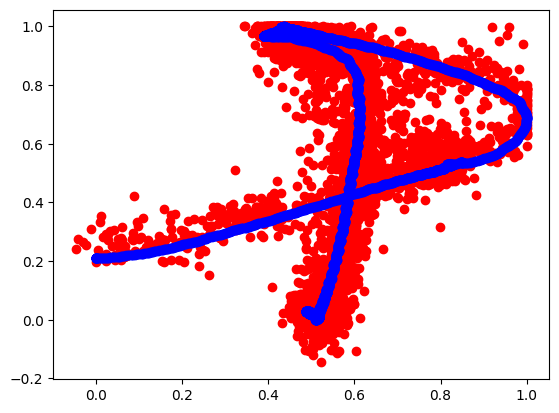

In [20]:
plt.scatter(yhatX, yhatY, color='red')
plt.scatter(Xtargets, Ytargets, color='blue')
plt.show()